## Online Learning for Stock Price Prediction

In this notebook, we will use ARTML's LDA Classifier to create a trading strategy using the Linear Discriminant Analysis.

1. Define the Problem
2. Data Preparation
3. Data Modelling
4. Real time feature selection
5. Incrementally updating the Model & selecting best features in real time
6. Analyze the performance: Results & Model Evaluation

### Defining Problem

Stock price prediction is one of the significant and most difficult tasks in the world of finance. Most traders rely on technical, fundamental & quantitative analysis for making predictions or generating price signals. The dependence of the Stock market on many factors including the unquantifiable human emotions makes the stock prices highly volatile and challenging to predict. 

With the advancement of Machine learning in many Industries, its ripple effect is also observed in the finance Industry and for the price predictions. Although many people argue that the prices are random walk and no patterns can be found, contrary to this there are strong arguments for the seasonality of the prices and patterns in the stock data. But here comes the main challenge, since stock prices are generated every second there can always be a drift in the data distribution making past data and models obsolete for generating current predictions. 


![image](https://static-news.moneycontrol.com/static-mcnews/2018/12/SENSEX_NSE_nifty_BSE_Stock-market-1-770x433.jpg)

Online learning algorithms can address these problems in a certain manner with Incremental learning approaches. Huge drawback of most of the online learning techniques is that there is no scope for decremental learning (Forget some of the past data) and no flexibility for real-time feature selection. In this article, we discuss the potential of ARTML technique to address the above-mentioned problems for accurately predicting the trend of the stock market. We will implement Naive Bayesian & Linear Discriminant Analysis classification algorithms for predicting the next day's return (Positive/Negative). 


### Data Preparation

For using ARTML for price signal prediction,  SPY ETF data from 1993 to 2019 is taken from the Yahoo finance. SPY or S&P 500 is an American stock market index based on the market capitalizations of 500 large companies having common stock listed on the NYSE, NASDAQ, or the Cboe BZX Exchange. The data includes Opening & closing prices, High & low prices and trade volumes for all the trading days from 1993 to 2019.

### Import the data

Import the data of SPY Data (S&P 500) from the csv file.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('SPY.csv',index_col=0)
data.index = pd.to_datetime(data.index)
data.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-20,282.160004,283.500000,280.320007,281.549988,281.549988,84609200
2019-03-21,280.640015,285.179993,280.589996,284.730011,284.730011,79550400
2019-03-22,283.220001,283.799988,279.179993,279.250000,279.250000,122458800


In [2]:
data = data.rename(columns={'Adj Close': 'Adj_Close'})

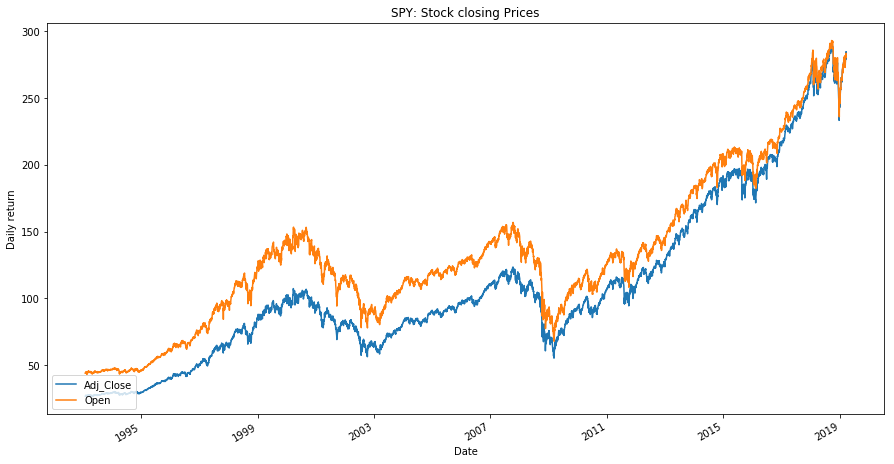

In [3]:
df_s = pd.DataFrame({'Adj_Close':data['Adj_Close'], 'Open': data['Open']})

daily_ax = df_s.plot(title='SPY: Stock closing Prices',figsize=(15,8))

daily_ax.set_ylabel('Daily return')
daily_ax.legend(loc='lower left')
plt.show()

Stock data is generally very clean and no further preprocessing or data cleaning is required other than feature engineering. Return, Standard deviations, and Volume of stocks traded for the different window periods (Window  = 2/5/10/20) are created as new features. Since we aim to do real-time feature selection it is always good to start with more number of features and select the best features from them at any point in time.


### Define predictor variables and a target variable

We define a list of predictors as listed below 
1. ret1 is the one-day returns, ret5 is the five-day returns etc.,
3. std5 is the five-day standard deviation etc.,
4. volume_by_adv20 is the volume divided by the 20-days average of daily volume and 
5. price differences (High - Low) and (Open - Close). <BR>

Syntax:
1. <font color='blue'>np.log(data[--]/data[--]/shift(1))</font> computes the log return from the immediately previous row by default.
2. <font color='blue'>rolling_sum(dataframe.column_name, window=n)</font> computes the sum of previous n rows.
3. <font color='blue'>rolling_std(dataframe.column_name, window=n)</font> computes the standard deviation of previous n rows.

A new feature of **‘Target’** is created by considering the next days closing price. If the consecutive trading day closing price is higher than the current closing price then return is considered to be positive/1. Our aim of this project is to build a real-time adaptive model to make this return prediction.

In [4]:
# Returns
import numpy as np
data['ret1'] = np.log(data['Adj_Close']/data['Adj_Close'].shift(1))
data['ret5'] = data['ret1'].rolling(window=5).sum()

data['ret10'] = data['ret1'].rolling(window=10).sum()
data['ret15'] = data['ret1'].rolling(window=15).sum()
data['ret2'] = data['ret1'].rolling(window=2).sum()
data['ret20'] = data['ret1'].rolling(window=20).sum()
data['ret30'] = data['ret1'].rolling(window=30).sum()


# Standard Deviation
data['std10'] = data['ret1'].rolling(window=10).std()
data['std15'] = data['ret1'].rolling(window=15).std()
data['std2'] = data['ret1'].rolling(window=2).std()
data['std5'] = data['ret1'].rolling(window=5).std()
data['std20'] = data['ret1'].rolling(window=20).std()


# Volume by ADV20
data['volume_by_adv20'] = data.Volume/data['Volume'].rolling(window=20).mean()
data['volume_by_adv10'] = data.Volume/data['Volume'].rolling(window=10).mean()
data['volume_by_adv5'] = data.Volume/data['Volume'].rolling(window=5).mean()
data['volume_by_adv2'] = data.Volume/data['Volume'].rolling(window=2).mean()

# High - low
data['H-L'] = data['High'] - data['Low']

# Open - Close
data['O-C'] = data['Close'] - data['Open']
data['O-C2'] = data['O-C'] * data['O-C']
data['H-L2'] = data['H-L'] * data['H-L']

In [5]:
# Future returns
data['retFut1'] = data.ret1.shift(-1)

Drop the NaN values and store the predictor variables in X and target variable in y. The target variable is 
- 1.0 if the one-day future returns are positive and 
- 0 if the returns are negative or zero.

In [6]:
#We define the target variable which is the future one-day returns.
data['Target'] =  np.where(data.retFut1 > 0.0, 1.0, 0)

In [7]:
# Define predictor variables (X) and a target variable (y)
data = data.dropna()
retFut1 = data.retFut1
data = data.drop(['retFut1'],1)
data.head()

,Open,High,Low,Close,Adj_Close,Volume,ret1,ret5,ret10,ret15,...,std20,volume_by_adv20,volume_by_adv10,volume_by_adv5,volume_by_adv2,H-L,O-C,O-C2,H-L2,Target
Date,,,,,,,,,,,,,,,,,,,,,
1993-03-15,45.0625,45.3125,45.0625,45.3125,27.676481,310800,0.004840,-0.009609,0.023022,0.035807,...,0.009625,1.508262,1.529678,1.118790,0.651299,0.2500,0.2500,0.062500,0.062500,0.0
1993-03-16,45.3125,45.4375,45.3125,45.3125,27.676481,30800,0.000000,-0.006186,0.008310,0.036521,...,0.007376,0.163079,0.163812,0.123151,0.180328,0.1250,0.0000,0.000000,0.015625,0.0
1993-03-17,45.2500,45.2500,44.9687,45.0312,27.504662,21800,-0.006227,-0.014469,-0.002081,0.017501,...,0.007586,0.121509,0.134410,0.101123,0.828897,0.2813,-0.2188,0.047873,0.079130,1.0
1993-03-18,45.2187,45.5000,45.2187,45.3125,27.676481,59300,0.006227,-0.005502,0.009702,0.021613,...,0.007623,0.362758,0.372558,0.278064,1.462392,0.2813,0.0938,0.008798,0.079130,0.0
1993-03-19,45.2812,45.2812,45.0312,45.0312,27.634562,66900,-0.001516,0.003325,0.010976,0.018688,...,0.007658,0.405283,0.413320,0.683211,1.060222,0.2500,-0.2500,0.062500,0.062500,0.0


In [8]:
# predictor_list = data.columns
predictor_list = ['H-L','O-C','ret1','ret5', 'ret2','ret15','ret10','std5','std2','std10','std15','volume_by_adv20','volume_by_adv10','volume_by_adv5','Target']
X = data[predictor_list]
y = data['Target']

### Split the data into train and test dataset

This step is required to verify if the Real time model we will create is any good. We will split the dataset into two parts, first 80% of the dataset will be used to create the model and the remaining 20% will be used as a test dataset.

After getting the 80% of the whole as the training data, we further divided it into parts so that we can use the parts of the data to update the model incrementally.

In [9]:
# Split the data into train and test dataset
from sklearn.model_selection import train_test_split

train_length = int(len(data)*0.80)

X_train = X[:train_length-1000]
X_test =  X[train_length:]

y_train = y[:train_length-1000]
y_test = y[train_length:]    

In [10]:
X_train1 = X[train_length-1000:train_length] 
y_train1 = y[train_length-1000:train_length]

# Testing set is further divided into parts. The idea is as we get the new data we can use it to update the model
X_test1 =  X_test[:500]
X_test2 =  X_test[500:1000]
X_test_val =  X_test[1000:]


y_test1 = y_test[:500]
y_test2 = y_test[500:1000]
y_test_val = y_test[1000:]

Since this is a Time series data, we cannot randomly split the data. Instead data is sliced into different sets in the same order.  (In real scenarios we can update the model with the new stock data and use these updated models for making the future predictions.) Here our main goal is to show how the drift in data distribution can be used to update the models to make better predictions. 

In [11]:
y_test_val.shape

(311,)

In [12]:
X_train.head()

,H-L,O-C,ret1,ret5,ret2,ret15,ret10,std5,std2,std10,std15,volume_by_adv20,volume_by_adv10,volume_by_adv5,Target
Date,,,,,,,,,,,,,,,
1993-03-15,0.2500,0.2500,0.004840,-0.009609,-5.501580e-03,0.035807,0.023022,0.005817,0.010736,0.009785,0.008484,1.508262,1.529678,1.118790,0.0
1993-03-16,0.1250,0.0000,0.000000,-0.006186,4.840417e-03,0.036521,0.008310,0.005798,0.003423,0.008764,0.008468,0.163079,0.163812,0.123151,0.0
1993-03-17,0.2813,-0.2188,-0.006227,-0.014469,-6.227474e-03,0.017501,-0.002081,0.005805,0.004403,0.008940,0.008227,0.121509,0.134410,0.101123,1.0
1993-03-18,0.2813,0.0938,0.006227,-0.005502,-6.938894e-17,0.021613,0.009702,0.007105,0.008807,0.008933,0.008328,0.362758,0.372558,0.278064,0.0
1993-03-19,0.2500,-0.2500,-0.001516,0.003325,4.711718e-03,0.018688,0.010976,0.005027,0.005475,0.008882,0.008363,0.405283,0.413320,0.683211,0.0


Often, there is a regime change in time series data, so that a model trained on data randomly selected through the dataset will outperform a model trained on data selected from an earlier part of the data, but the latter will be more realistic. Also, if we are forced to select from an earlier part of the data, there is no way to ensure that the statistics of the train and test set are the same (i.e. equal % of classes in each), but that again is realistic. In trading applications, we normally don't have truly stationary statistics, and a ML strategy needs to be robust enough to withstand that.

### Data Modelling

Linear Discriminant Analysis (LDA) algorithm is used for making the return predictions in our case. Check previous articles for the math of LDA

In [13]:
#creating the Basic Element table
from artml import bet
BET =  bet.create_bet(X_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 197.59it/s]


In [14]:
# Descriptive Stats 
from artml.explore import stats
df_stats = stats.univariate(BET)
df_stats

,H-L,O-C,ret1,ret5,ret2,ret15,ret10,std5,std2,std10,std15,volume_by_adv20,volume_by_adv10,volume_by_adv5,Target
count,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
Mean,1.526229,-0.022259,0.000292,0.001448,0.000580,0.004364,0.002900,0.010240,0.008758,0.010567,0.010647,1.023474,1.014031,1.007673,0.529231
Variance,1.395850,1.340082,0.000157,0.000639,0.000293,0.001695,0.001146,0.000060,0.000091,0.000050,0.000047,0.255254,0.194134,0.137702,0.249146
Standard_deviation,1.181461,1.157619,0.012531,0.025270,0.017123,0.041167,0.033851,0.007714,0.009528,0.007081,0.006847,0.505227,0.440606,0.371082,0.499145
coeff_of_variation,77.410456,-5200.617234,4285.941156,1745.651575,2950.469300,943.280986,1167.369566,75.330936,108.786914,67.011906,64.303838,49.363927,43.450989,36.825623,94.315020
skewness,2.264078,-0.226067,-0.044400,-0.760759,-0.359220,-1.171934,-1.079610,3.298936,3.552078,3.034625,2.967751,3.953316,2.357240,1.327725,-0.117209
Kurtosis,9.532816,6.406442,10.431495,7.076364,6.424663,6.164803,7.363292,19.545196,22.408239,15.191266,14.195696,47.671096,15.715660,5.434823,-1.986730


In [15]:
# Training the LDA model
from artml.models import lda
lda = lda.LinearDiscriminantAnalysis()
lda.fit(BET, 'Target')

## Predict using the LDA

We define a trading rule based on the predicted value from the LDA. If the predicted value is positive then we buy (+1) the stock and otherwise, we don't buy the stock. This signal is stored in predicted_signal. The strategy returns are generated by multiplying the future one-day returns by the predicted signal and stored in the strategy_returns_nn. 

In [16]:
X = X.drop(['Target'],1)
X_test_val = X_test_val.drop(['Target'],1)
data['predicted_signal'] = lda.predict(X)
data.retFut1 = retFut1
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal
# data.head(10)

## Performance of the LDA

Binary classification evaluation metrics like Precision/Recall & accuracy can be used for evaluating the model. Since precision represents the number of relevant results, this clearly shows the percentage of positive return predictions made by the model. Also, CAGR (Compound Annual Growth Rate) & Sharpe ratio are calculated for evaluating the trading strategy. 

### Sharpe Ratio

The Sharpe ratio is calculated as follows:

<img src="https://d2a032ejo53cab.cloudfront.net/Glossary/R2TAJa6K/Sharpe-1.jpg"></img>

Where
- N is the number of trading days in a year
- Rf is the risk-free rate
- Std dev is the standard deviation

Sharpe ratio represents how good the strategy performance is for the risk (standard deviation) taken to achieve it. The higher the Sharpe ratio the better is the strategy. Generally, a Sharpe ratio of greater than 1.5 is preferred.

In [17]:
# The below function returns the Sharpe ratio for the excess returns (Strategy returns - Risk free rate) passed to it.
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

We calculate the Sharpe ratio for the strategy in train and test dataset. The risk-free rate is assumed to be 5% p.a.

In [18]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length-1000])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length+300:])

### Strategy CAGR
CAGR represents the compounded annual returns of the strategy. The strategy CAGR is computed as follows:

<i>(Cumulative returns + 1)^(252/number of days) - 1</i>

where cumulative returns are the total strategy returns and number of days represent the total trading days.

In [19]:
def CAGR(returns):
    cumulative_returns = returns.cumsum().iloc[-1]   
    period_in_days = len(returns)
    return 100*((cumulative_returns+1)**(252.0/period_in_days)-1)

We compute the strategy CAGR in train and test dataset.

In [20]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length-1000])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length+300:])

#### Plot cumulative returns in train dataset

In [21]:
import matplotlib.pyplot as plt
import seaborn

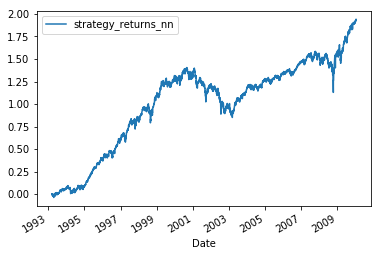

In [22]:
# Plot the cumulative returns for LDA in train dataset
data.strategy_returns_nn[:train_length-1000].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

#### Plot cumulative returns in test dataset

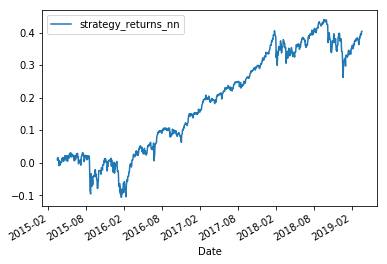

In [23]:
# Plot the cumulative returns for LDA in test dataset
data.strategy_returns_nn[train_length+300:].cumsum().plot()

# Show the legend
plt.legend()

# Show the graph
plt.show()

#### Strategy Results

In [24]:
from tabulate import tabulate

print (tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl'))

|              |    Train |     Test |
|--------------+----------+----------|
| CAGR         | 6.61459  | 8.83027  |
| Sharpe Ratio | 0.361243 | 0.381322 |


####  LDA Model Evaluation

The classification_report function from sklearn.metrics package is used to analyze the performance of the LDA. The classification_report takes as input the actual output and the predicted output.

In [25]:
X_test_val.shape

(311, 14)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test_val, lda.predict(X_test_val)))

             precision    recall  f1-score   support

        0.0       0.41      0.06      0.11       140
        1.0       0.55      0.92      0.69       171

avg / total       0.48      0.54      0.43       311



### Real Time Feature Selection to improve model performance

In [27]:
#Importing feature_selection algorithm from artml library
from artml.feature_selection import mahalanobis_features
best = mahalanobis_features.mahalanobis_selection()

In [28]:
# Always make sure that the index is same as the feature names
BET.index = list(BET.columns)
# alpha is a hyperparameter which can be varied to select different number of features
features = best.forward_selection(BET,'Target', alpha=1.05)
features

['ret5', 'std2', 'ret10', 'ret1', 'volume_by_adv20']

In [29]:
# add Target variable in the list of best features
bestfeatures = features
bestfeatures.append('Target')
bestfeatures

['ret5', 'std2', 'ret10', 'ret1', 'volume_by_adv20', 'Target']

In [30]:
# select only best features from the BET table
BET_best= BET.loc[bestfeatures]
BET_best= BET_best[bestfeatures]

In [31]:
# Build new LDA model with the selected features
from artml.models import lda
lda = lda.LinearDiscriminantAnalysis()
lda.fit(BET_best, 'Target')

In [32]:
features.remove('Target')

In [33]:
# X = X.drop(['Target'],1)
# X_test_val = X_test_val.drop(['Target'],1)
data['predicted_signal'] = lda.predict(X[features])
data.retFut1 = retFut1
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal
# data.head(10)

In [34]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length-1000])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length+300:])

In [35]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length-1000])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length+300:])

In [36]:
from tabulate import tabulate

print (tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl'))

|              |    Train |    Test |
|--------------+----------+---------|
| CAGR         | 5.88694  | 8.37441 |
| Sharpe Ratio | 0.258424 | 0.33718 |


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test_val, lda.predict(X_test_val[features])))

             precision    recall  f1-score   support

        0.0       0.33      0.06      0.10       140
        1.0       0.54      0.91      0.68       171

avg / total       0.45      0.52      0.42       311



### 1. Incrementally updating the Model & selecting best features in real time

In [38]:
BET1 =  bet.create_bet(X_train1)
BET =  bet.create_bet(X_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 175.51it/s]


In [39]:
BET_updated = BET + BET1

In [40]:
BET_updated.index = list(BET_updated.columns)

features = best.forward_selection(BET_updated,'Target', alpha=1.05)
features

['ret5', 'std2', 'ret10', 'O-C']

In [41]:
bestfeatures = features
bestfeatures.append('Target')
bestfeatures

['ret5', 'std2', 'ret10', 'O-C', 'Target']

In [42]:
BET_best= BET_updated.loc[bestfeatures]
BET_best= BET_best[bestfeatures]

In [43]:
from artml.models import lda
lda = lda.LinearDiscriminantAnalysis()
lda.fit(BET_best, 'Target')

In [44]:
features.remove('Target')

In [45]:
data['predicted_signal'] = lda.predict(X[features])
data.retFut1 = retFut1
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal

In [46]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length-1000])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length+300:])

In [47]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length-1000])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length+300:])

In [48]:
from tabulate import tabulate

print (tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl'))

|              |    Train |     Test |
|--------------+----------+----------|
| CAGR         | 5.77239  | 9.82158  |
| Sharpe Ratio | 0.253437 | 0.495021 |


In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test_val, lda.predict(X_test_val[features])))

             precision    recall  f1-score   support

        0.0       0.44      0.19      0.26       140
        1.0       0.55      0.81      0.65       171

avg / total       0.50      0.53      0.48       311



### 2. Incrementally updating the Model & selecting best features in real time

In [50]:
BET1 =  bet.create_bet(X_train1)
BET =  bet.create_bet(X_train)
BET2 =  bet.create_bet(X_test1)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 937.50it/s]


In [51]:
BET_updated1 = BET + BET1 + BET2

In [52]:
BET_updated1.index = list(BET_updated1.columns)
features = best.forward_selection(BET_updated1,'Target', alpha=1.05)
features

['ret5', 'std2', 'ret10', 'O-C']

In [53]:
bestfeatures = features
bestfeatures.append('Target')
bestfeatures

['ret5', 'std2', 'ret10', 'O-C', 'Target']

In [54]:
BET_best= BET_updated1.loc[bestfeatures]
BET_best= BET_best[bestfeatures]

In [55]:
from artml.models import lda
lda = lda.LinearDiscriminantAnalysis()
lda.fit(BET_best, 'Target')

In [56]:
features.remove('Target')

In [57]:
data['predicted_signal'] = lda.predict(X[features])
data.retFut1 = retFut1
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal

In [58]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length-1000])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length+300:])

In [59]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length-1000])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length+300:])

In [60]:
from tabulate import tabulate

print (tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl'))

|              |    Train |     Test |
|--------------+----------+----------|
| CAGR         | 6.21628  | 9.55275  |
| Sharpe Ratio | 0.315816 | 0.465058 |


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test_val, lda.predict(X_test_val[features])))

             precision    recall  f1-score   support

        0.0       0.43      0.17      0.24       140
        1.0       0.55      0.81      0.65       171

avg / total       0.49      0.52      0.47       311



### 3. Incrementally updating the Model & selecting best features in real time

In [62]:
BET1 =  bet.create_bet(X_train1)
BET =  bet.create_bet(X_train)
BET2 =  bet.create_bet(X_test1)
BET3 =  bet.create_bet(X_test2)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 935.73it/s]


In [63]:
BET_updated2 = BET + BET1 + BET2 + BET3

In [64]:
BET_updated2.index = list(BET_updated2.columns)
features = best.forward_selection(BET_updated2,'Target', alpha=1.15)
features

['ret5', 'O-C', 'std2', 'ret10']

In [65]:
bestfeatures = features
bestfeatures.append('Target')
bestfeatures

['ret5', 'O-C', 'std2', 'ret10', 'Target']

In [66]:
BET_best= BET_updated2.loc[bestfeatures]
BET_best= BET_best[bestfeatures]

In [67]:
from artml.models import lda
lda = lda.LinearDiscriminantAnalysis()
lda.fit(BET_best, 'Target')

In [68]:
features.remove('Target')

In [69]:
data['predicted_signal'] = lda.predict(X[features])
data.retFut1 = retFut1
data['strategy_returns_nn'] = data.retFut1 * data.predicted_signal

In [70]:
# Sharpe ratio
# Train dataset
data['excess_daily_strategy_return'] = data.strategy_returns_nn - 0.05/252
sharpe_train_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[:train_length-1000])
# Test dataset
sharpe_test_nn = annualized_sharpe_ratio(data.excess_daily_strategy_return.iloc[train_length+300:])

In [71]:
# CAGR
# Train dataset
ret_train_nn = CAGR(data.strategy_returns_nn.iloc[:train_length-1000])
# Test dataset
ret_test_nn = CAGR(data.strategy_returns_nn.iloc[train_length+300:])

In [72]:
from tabulate import tabulate

print (tabulate(
        [             
            ['CAGR', ret_train_nn, ret_test_nn],
            ['Sharpe Ratio', sharpe_train_nn, sharpe_test_nn],
        ], 
        headers=['Train', 'Test'], 
    tablefmt='orgtbl'))

|              |    Train |     Test |
|--------------+----------+----------|
| CAGR         | 5.77315  | 8.42173  |
| Sharpe Ratio | 0.252257 | 0.353943 |


In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_test_val, lda.predict(X_test_val[features])))

             precision    recall  f1-score   support

        0.0       0.38      0.17      0.24       140
        1.0       0.53      0.77      0.63       171

avg / total       0.46      0.50      0.45       311



### Model Deployment:

The True power of ARTML can be exploited during the deployment. Once the model with a particular trading strategy is built and deployed, the model can be continuously updated with the ever-increasing new labeled data that is generated every second. When the model gets updated with some anomaly data which is common in the stock market (Variations due to temporary political changes etc.,) ARTML models have the power to forget these data points. Also, Basic element table can be built considering all fundamental, technical & economic factors and only features that gives better classifier performance can be selected in real time. These flexibilities make ARTML highly powerful for real-time stock market predictions. 


### References:

 - https://finance.yahoo.com/quote/SPY?p=SPY
 - https://www.investopedia.com/terms/s/sharperatio.asp
 - https://www.investopedia.com/terms/c/cagr.asp
 - http://cs229.stanford.edu/proj2017/final-reports/5212256.pdf
 -https://www.researchgate.net/publication/309492895_Forecasting_to_Classification_Predicting_the_direction_of_stock_market_price_using_Xtreme_Gradient_Boosting


------------------------------------------------------------------------------------------------------